# Movie Recommendation System

This notebook focuses on building an recommendation system for streaming service provider. Using this system, providers can recommend titles to their subscribers (users) tha they are ikely to watch/like. Such as system can be very useful for the business as this will increase the user engagement and may result in reduction of churn rate. We will use data from [The Movie Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) available on Kaggle. The goal is to leverage this dataset to recommend movies to users on a streaming platform.


#### Dataset

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

#### Content of Dataset
This dataset consists of the following files:

**movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

**keywords.csv:** Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

**credits.csv:** Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

**links.csv:** The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

**links_small.csv:** Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

**ratings_small.csv:** The subset of 100,000 ratings from 700 users on 9,000 movies.

#### Steps involved in building a Recommendation System in this project:

1.  **Data Loading**: Loading the necessary datasets (`movies_metadata.csv`, `ratings_small.csv`, `links_small.csv`, and `keywords.csv`).
2.  **Data Cleaning and Preprocessing**: Addressing inconsistencies, missing values, and data type issues in the loaded dataframes to prepare them for merging.
3.  **Data Merging**: Combining the cleaned dataframes into a single comprehensive dataframe based on common movie identifiers.
4.  **Handling Duplicates**: Identifying and removing any duplicate entries that may have been introduced during the merging process.
5.  **Final Dataframe Preparation**: Selecting relevant columns and ensuring the final dataframe is in a suitable format for building a recommendation system.
6.  **Model Development**: Building and training a recommendation model using the prepared data. This could involve various techniques such as collaborative filtering, content-based filtering, or a hybrid approach.
7.  **Model Evaluation**: Evaluating the performance of the recommendation model using appropriate metrics.
8.  **Recommendation Generation**: Using the trained model to generate personalized movie recommendations for users.

By following these steps and using the available dataset, we will create a recommendation system and provide personalized movie suggestions to users.

# Import data

I am using smaller version of the dataset for ratings (ratings_small) and links (links_small) for this project. The larger version has too many rows which crashes the colab notebook. The smaller version has enough data with at least 20 reviews per user to build a recommendation system.

In [34]:
import pandas as pd
from google.colab import drive
import os
import json
import numpy
!pip install surprise


# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive
folder_path = '/content/drive/MyDrive/movie_lens_dataset'

# List all files in the folder
files = os.listdir(folder_path)

# Filter for CSV files
csv_files = [f for f in files if f.endswith('.csv')]

# Import each CSV file into a separate dataframe
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df_name = os.path.splitext(csv_file)[0].replace('.', '_') + '_df'
    try:
        df = pd.read_csv(file_path, engine='python')
        globals()[df_name] = df
        print(f"Loaded {csv_file} into {df_name}")
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded credits.csv into credits_df
Loaded links_small.csv into links_small_df
Loaded movies_metadata.csv into movies_metadata_df
Loaded keywords.csv into keywords_df
Loaded ratings_small.csv into ratings_small_df


In [35]:
print("Number of ratings in ratings_small_df:", len(ratings_small_df))

Number of ratings in ratings_small_df: 100004


## Exploratory Data Analysis (EDA) and Data Preperation

Address any inconsistencies, missing values, or data type issues in the relevant columns before merging. This might involve handling different identifier types (e.g., 'id' vs 'tmdbId'), converting data types, or cleaning string data in columns like 'genres' or 'keywords'.


Inspect the data types and values of the identifier columns in `movies_metadata_df`, `links_df`, and `keywords_df` to prepare for merging.



In [36]:
print("Data types of identifier columns:")
print("movies_metadata_df['id']:", movies_metadata_df['id'].dtype)
print("links_small_df['tmdbId']:", links_small_df['tmdbId'].dtype) # Changed to links_small_df
print("keywords_df['id']:", keywords_df['id'].dtype)

print("\nUnique non-numeric values in movies_metadata_df['id']:")
non_numeric_ids_movies = movies_metadata_df[pd.to_numeric(movies_metadata_df['id'], errors='coerce').isna()]['id'].unique()
print(non_numeric_ids_movies)

print("\nMissing values in identifier columns:")
print("movies_metadata_df['id'] missing:", movies_metadata_df['id'].isnull().sum())
print("links_small_df['tmdbId'] missing:", links_small_df['tmdbId'].isnull().sum()) # Changed to links_small_df
print("keywords_df['id'] missing:", keywords_df['id'].isnull().sum())

Data types of identifier columns:
movies_metadata_df['id']: object
links_small_df['tmdbId']: float64
keywords_df['id']: int64

Unique non-numeric values in movies_metadata_df['id']:
['1997-08-20' '2012-09-29' '2014-01-01']

Missing values in identifier columns:
movies_metadata_df['id'] missing: 0
links_small_df['tmdbId'] missing: 13
keywords_df['id'] missing: 0


Based on the inspection, the 'id' column in `movies_metadata_df` has non-numeric values and is of object type. The 'tmdbId' in `links_df` is float64 and has missing values. The 'id' in `keywords_df` is int64.

Convert the 'id' in `movies_metadata_df` to numeric, handling errors by coercing them to NaN and then dropping rows with NaN. Also, convert 'tmdbId' in `links_df` to integer after dropping rows with missing values, as tmdbIds are typically integers.



In [37]:
# Handle non-numeric and missing values in identifier columns

# Convert 'id' in movies_metadata_df to numeric, coercing errors to NaN
movies_metadata_df['id'] = pd.to_numeric(movies_metadata_df['id'], errors='coerce')

# Drop rows with NaN in the 'id' column of movies_metadata_df
movies_metadata_df.dropna(subset=['id'], inplace=True)

# Convert 'id' in movies_metadata_df to integer
movies_metadata_df['id'] = movies_metadata_df['id'].astype(int)

# Drop rows with missing 'tmdbId' in links_small_df
links_small_df.dropna(subset=['tmdbId'], inplace=True)

# Convert 'tmdbId' in links_small_df to integer
links_small_df['tmdbId'] = links_small_df['tmdbId'].astype(int)

# Verify the data types and missing values after cleaning
print("Data types of identifier columns after cleaning:")
print("movies_metadata_df['id']:", movies_metadata_df['id'].dtype)
print("links_small_df['tmdbId']:", links_small_df['tmdbId'].dtype) # Changed to links_small_df
print("keywords_df['id']:", keywords_df['id'].dtype)

print("\nMissing values in identifier columns after cleaning:")
print("movies_metadata_df['id'] missing:", movies_metadata_df['id'].isnull().sum())
print("links_small_df['tmdbId'] missing:", links_small_df['tmdbId'].isnull().sum()) # Changed to links_small_df
print("keywords_df['id'] missing:", keywords_df['id'].isnull().sum())

Data types of identifier columns after cleaning:
movies_metadata_df['id']: int64
links_small_df['tmdbId']: int64
keywords_df['id']: int64

Missing values in identifier columns after cleaning:
movies_metadata_df['id'] missing: 0
links_small_df['tmdbId'] missing: 0
keywords_df['id'] missing: 0


Now that the identifier columns are cleaned and have consistent data types, inspect the 'genres' and 'keywords' columns, which contain string representations of lists of dictionaries, and the 'vote_average', 'vote_count', and 'rating' columns for data types and missing values. Convert the string representations in 'genres' and 'keywords' to actual lists of dictionaries and handle any missing values in these columns and the rating-related columns.



In [38]:
# Inspect data types and missing values for 'genres', 'keywords', 'vote_average', 'vote_count', and 'rating'
print("\nData types of feature columns:")
print("movies_metadata_df['genres']:", movies_metadata_df['genres'].dtype)
print("keywords_df['keywords']:", keywords_df['keywords'].dtype)
print("movies_metadata_df['vote_average']:", movies_metadata_df['vote_average'].dtype)
print("movies_metadata_df['vote_count']:", movies_metadata_df['vote_count'].dtype)
print("ratings_small_df['rating']:", ratings_small_df['rating'].dtype)

print("\nMissing values in feature columns:")
print("movies_metadata_df['genres'] missing:", movies_metadata_df['genres'].isnull().sum())
print("keywords_df['keywords'] missing:", keywords_df['keywords'].isnull().sum())
print("movies_metadata_df['vote_average'] missing:", movies_metadata_df['vote_average'].isnull().sum())
print("movies_metadata_df['vote_count'] missing:", movies_metadata_df['vote_count'].isnull().sum())
print("ratings_small_df['rating'] missing:", ratings_small_df['rating'].isnull().sum())

# Function to safely load JSON, returning empty list on error
def safe_json_load(x):
    try:
        return json.loads(x)
    except (json.JSONDecodeError, TypeError):
        return []

# Convert string representation of lists of dictionaries to actual lists of dictionaries, handling errors
for col in ['genres']:
    movies_metadata_df[col] = movies_metadata_df[col].apply(safe_json_load)

for col in ['keywords']:
    keywords_df[col] = keywords_df[col].apply(safe_json_load)

# Fill missing values in 'vote_average' and 'vote_count' with 0
movies_metadata_df['vote_average'] = movies_metadata_df['vote_average'].fillna(0)
movies_metadata_df['vote_count'] = movies_metadata_df['vote_count'].fillna(0)


# Verify the data types after conversion
print("\nData types of feature columns after cleaning:")
print("movies_metadata_df['genres']:", movies_metadata_df['genres'].dtype)
print("keywords_df['keywords']:", keywords_df['keywords'].dtype)


Data types of feature columns:
movies_metadata_df['genres']: object
keywords_df['keywords']: object
movies_metadata_df['vote_average']: float64
movies_metadata_df['vote_count']: float64
ratings_small_df['rating']: float64

Missing values in feature columns:
movies_metadata_df['genres'] missing: 0
keywords_df['keywords'] missing: 0
movies_metadata_df['vote_average'] missing: 3
movies_metadata_df['vote_count'] missing: 3
ratings_small_df['rating'] missing: 0

Data types of feature columns after cleaning:
movies_metadata_df['genres']: object
keywords_df['keywords']: object


## Merge dataframes

Perform appropriate merges based on common columns (like movie or user identifiers) to combine the relevant information into a single dataframe. This will have to perform multiple merge operations.


In [39]:
# Merge movies_metadata_df and keywords_df on 'id'
movies_keywords_df = pd.merge(movies_metadata_df, keywords_df, on='id', how='inner')

# Merge movies_keywords_df and links_small_df on movie identifiers
# movies_keywords_df uses 'id' and links_small_df uses 'tmdbId'
movies_links_small_df = pd.merge(movies_keywords_df, links_small_df, left_on='id', right_on='tmdbId', how='inner')

# Merge ratings_small_df and movies_links_small_df on their movie identifier columns
# ratings_small_df uses 'movieId' and movies_links_small_df uses 'movieId'
merged_df = pd.merge(ratings_small_df, movies_links_small_df, on='movieId', how='inner')

# Display the head of the final merged dataframe
display(merged_df.head())

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,id,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,imdbId,tmdbId
0,1,31,2.5,1260759144,False,NaN,0,[],NaN,9909,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,She broke the rules... and changed their lives.,Dangerous Minds,False,6.4,249.0,[],112792,9909
1,1,1029,3.0,1260759179,False,NaN,812000,[],NaN,11360,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The One...The Only...The FABULOUS...,Dumbo,False,6.8,1206.0,[],33563,11360
2,1,1061,3.0,1260759182,False,NaN,44000000,[],NaN,819,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,When friendship runs deeper than blood.,Sleepers,False,7.3,729.0,[],117665,819
3,1,1129,2.0,1260759185,False,"{'id': 115838, 'name': 'Escape From ... Collec...",6000000,[],http://www.theofficialjohncarpenter.com/escape...,1103,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,1997. New York City is now a maximum security ...,Escape from New York,False,6.9,720.0,[],82340,1103
4,1,1172,4.0,1260759205,False,NaN,0,[],NaN,11216,...,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,"A celebration of youth, friendship, and the ev...",Cinema Paradiso,False,8.2,834.0,[],95765,11216


## Handle duplicate data and Identify relevant columns

Check for and address any duplicate entries that might arise from the merging process. Also, identify relevant columns for building a recommendation system


In [40]:
# Handle duplicate rows by converting list columns to strings temporarily for duplicate checking
merged_df_temp = merged_df.copy()

# Convert list columns to string representation for duplicate checking
for col in ['genres', 'keywords']:
    if col in merged_df_temp.columns:
        merged_df_temp[col] = merged_df_temp[col].astype(str)

# Check for duplicate rows using the temporary dataframe
initial_duplicates = merged_df_temp.duplicated().sum()
print(f"Initial number of duplicate rows: {initial_duplicates}")

# Remove duplicate rows from the original merged_df if they exist
if initial_duplicates > 0:
    # Use the boolean mask from the temporary dataframe to drop duplicates in the original dataframe
    merged_df = merged_df[~merged_df_temp.duplicated()]
    print("Duplicate rows removed.")

# Verify that duplicates have been removed by checking on the filtered temporary dataframe
duplicates_after_removal = merged_df_temp[~merged_df_temp.duplicated()].duplicated().sum()
print(f"Number of duplicate rows after removal: {duplicates_after_removal}")

Initial number of duplicate rows: 126
Duplicate rows removed.
Number of duplicate rows after removal: 0


In [41]:
# Define the relevant columns for the final recommendation dataframe
recommendation_cols = ['userId', 'movieId', 'rating', 'title', 'genres', 'keywords', 'vote_average', 'vote_count']

# Create the final recommendation dataframe with only the selected columns
recommendation_df = merged_df[recommendation_cols]

# Display the head of the final recommendation dataframe
display(recommendation_df.head())

,userId,movieId,rating,title,genres,keywords,vote_average,vote_count
0,1,31,2.5,Dangerous Minds,[],[],6.4,249.0
1,1,1029,3.0,Dumbo,[],[],6.8,1206.0
2,1,1061,3.0,Sleepers,[],[],7.3,729.0
3,1,1129,2.0,Escape from New York,[],[],6.9,720.0
4,1,1172,4.0,Cinema Paradiso,[],[],8.2,834.0


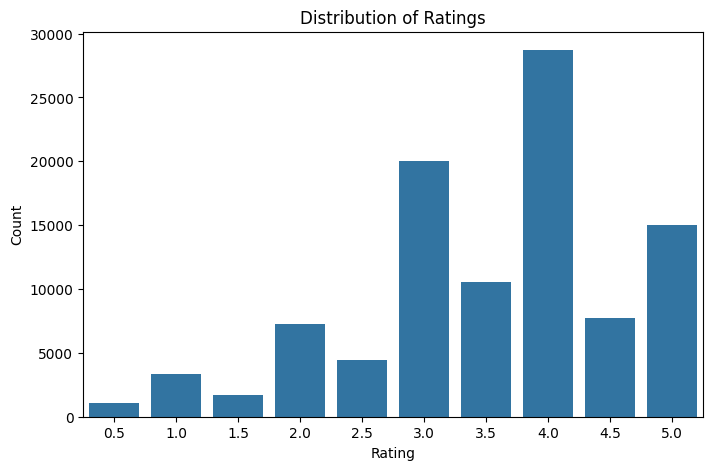

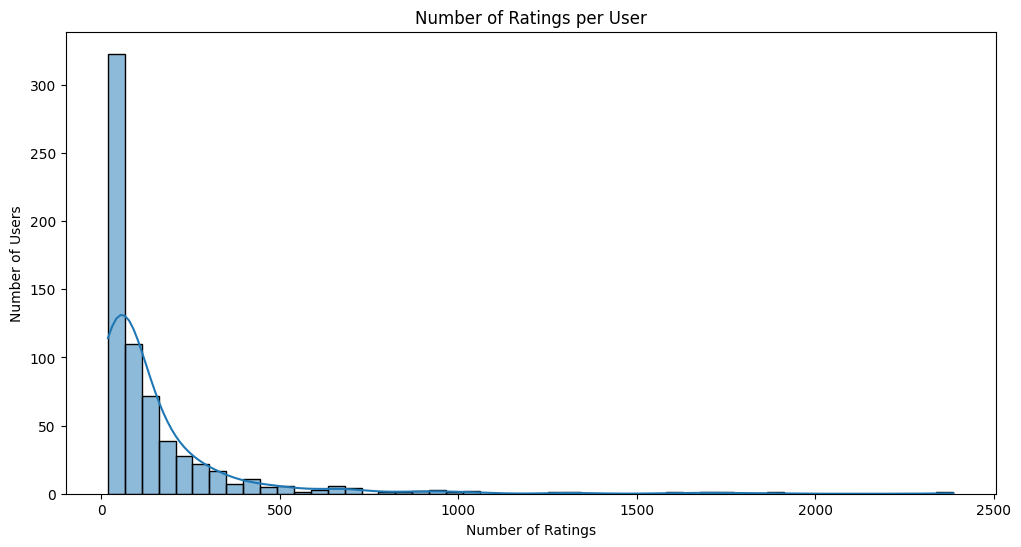

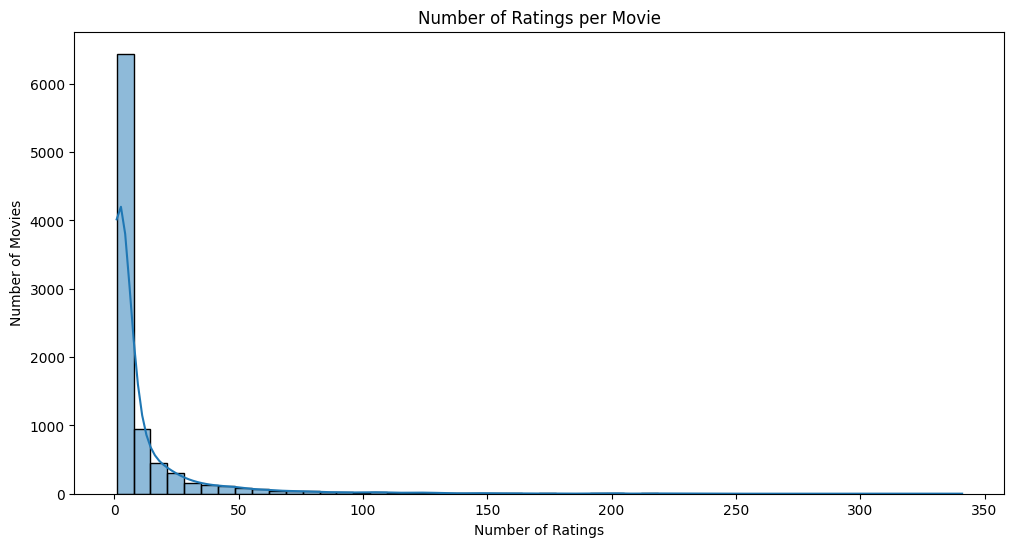

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=recommendation_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Visualize the number of ratings per user
user_ratings_count = recommendation_df['userId'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_count, bins=50, kde=True)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

# Visualize the number of ratings per movie
movie_ratings_count = recommendation_df['movieId'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings_count, bins=50, kde=True)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

## Build a Recommendation System
Build a recommendation system from the dataset using Collaborative Filtering and Matrix Factorization techniques.

In [43]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# We will use 80% of the data for training and 20% for testing
train_df, test_df = train_test_split(recommendation_df, test_size=0.2, random_state=42)

print("Shape of training data:", train_df.shape)
print("Shape of testing data:", test_df.shape)

# Now, the next steps of creating the user-item matrix and training the NMF model
# need to be done using the 'train_df'. The 'test_df' will be used for evaluation.

Shape of training data: (79868, 8)
Shape of testing data: (19968, 8)


In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Create a user-item matrix (pivot table)
# Fill missing values with 0, as cosine similarity requires non-NaN values.
# Note: This might not be the ideal way to handle missing values for all similarity metrics,
# but it's a common approach for cosine similarity in this context.
user_item_pivot = recommendation_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Calculate item similarity using cosine similarity on the transposed user-item matrix
# We transpose because we want to calculate similarity between columns (movies)
item_similarity_matrix = cosine_similarity(user_item_pivot.T)

# Convert the similarity matrix to a pandas DataFrame for easier handling
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_item_pivot.columns, columns=user_item_pivot.columns)

print("Item Similarity Matrix calculated.")
display(item_similarity_df.head())

# Function to get top N similar movies for a given movie
def get_similar_movies(movie_id, item_similarity_df, n=10):
    if movie_id not in item_similarity_df.index:
        return f"Movie ID {movie_id} not found in the dataset."

    # Get the similarity scores for the given movie
    similarity_scores = item_similarity_df[movie_id]

    # Sort movies by similarity score and exclude the movie itself
    # We use iloc to get the original index which is the movie ID
    similar_movies = similarity_scores.sort_values(ascending=False).drop(movie_id).head(n)

    # Get the movie titles for the similar movies
    recommended_movies_info_list = []
    for similar_movie_id, score in similar_movies.items():
        movie_info = movies_metadata_df[movies_metadata_df['id'] == similar_movie_id][['id', 'title']]
        if not movie_info.empty:
            recommended_movies_info_list.append({'id': similar_movie_id, 'title': movie_info.iloc[0]['title'], 'similarity_score': score})
        else:
             recommended_movies_info_list.append({'id': similar_movie_id, 'title': 'Title Not Found', 'similarity_score': score})


    return pd.DataFrame(recommended_movies_info_list)


# Example: Get similar movies for a specific movie (e.g., MovieId 356 - Forrest Gump)
# You might need to check if this movieId exists in your recommendation_df and movies_metadata_df
example_movie_id = 356
if example_movie_id in item_similarity_df.index:
    similar_movies = get_similar_movies(example_movie_id, item_similarity_df)
    print(f"\nTop 10 similar movies for Movie ID {example_movie_id}:")
    display(similar_movies)
else:
    print(f"\nMovie ID {example_movie_id} not found in the dataset for similarity calculation.")

# Function to recommend movies for a specific user based on Item-Based Collaborative Filtering
def recommend_movies_item_based(user_id, user_item_pivot, item_similarity_df, movies_metadata_df, n=10):
    if user_id not in user_item_pivot.index:
        return f"User ID {user_id} not found in the dataset."

    # Get the movies rated by the user
    user_ratings = user_item_pivot.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()

    if not rated_movies:
        return "User has not rated any movies."

    # Calculate the weighted sum of similarity scores for unrated movies
    # Initialize a dictionary to store predicted scores
    predicted_scores = {}
    # Initialize a dictionary to store sum of similarities for normalization
    sum_of_similarities = {}

    for rated_movie_id in rated_movies:
         if rated_movie_id in item_similarity_df.index:
            # Get similar movies for the rated movie
            similar_items = item_similarity_df[rated_movie_id].drop(rated_movie_id) # Exclude the movie itself

            for similar_movie_id, similarity in similar_items.items():
                # Only consider movies the user hasn't rated
                if user_ratings[similar_movie_id] == 0:
                    if similar_movie_id not in predicted_scores:
                        predicted_scores[similar_movie_id] = 0
                        sum_of_similarities[similar_movie_id] = 0

                    predicted_scores[similar_movie_id] += similarity * user_ratings[rated_movie_id]
                    sum_of_similarities[similar_movie_id] += similarity

    # Normalize the predicted scores
    for movie_id in predicted_scores:
        if sum_of_similarities[movie_id] > 0:
            predicted_scores[movie_id] /= sum_of_similarities[movie_id]
        else:
            predicted_scores[movie_id] = 0 # Avoid division by zero

    # Sort the predicted scores in descending order
    recommended_movies = pd.Series(predicted_scores).sort_values(ascending=False).head(n)

    # Get movie titles for recommendations safely
    recommended_movies_info_list = []
    for movie_id, score in recommended_movies.items():
        movie_info = movies_metadata_df[movies_metadata_df['id'] == movie_id][['id', 'title']]
        if not movie_info.empty:
            recommended_movies_info_list.append({'id': movie_id, 'title': movie_info.iloc[0]['title'], 'predicted_rating': score})
        else:
             recommended_movies_info_list.append({'id': movie_id, 'title': 'Title Not Found', 'predicted_rating': score})

    return pd.DataFrame(recommended_movies_info_list)


# Example: Get recommendations for a specific user (e.g., userId = 1)
# You might need to check if this userId exists in your recommendation_df
example_user_id = 1
if example_user_id in user_item_pivot.index:
    user_recommendations = recommend_movies_item_based(example_user_id, user_item_pivot, item_similarity_df, movies_metadata_df)
    print(f"\nTop 10 Item-Based Recommendations for User ID {example_user_id}:")
    display(user_recommendations)
else:
    print(f"\nUser ID {example_user_id} not found in the dataset for recommendation.")

Item Similarity Matrix calculated.


movieId,1,2,3,4,5,6,7,8,9,10,...,160718,161084,161155,161594,161830,161918,161944,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.0,0.0,0.000000
3,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.0,0.0,0.000000



Top 10 similar movies for Movie ID 356:


,id,title,similarity_score
0,480,Monsoon Wedding,0.688040
1,593,Solaris,0.667731
2,110,Three Colors: Red,0.658261
3,318,The Million Dollar Hotel,0.657244
4,296,Terminator 3: Rise of the Machines,0.655243
5,377,A Nightmare on Elm Street,0.627626
6,457,Sissi,0.622488
7,589,Title Not Found,0.619415
8,1270,Title Not Found,0.608397
9,364,Batman Returns,0.602429



Top 10 Item-Based Recommendations for User ID 1:


,id,title,predicted_rating
0,152017,Title Not Found,4.0
1,161944,Title Not Found,4.0
2,64278,Interceptor Force 2,4.0
3,97826,Title Not Found,4.0
4,98963,Title Not Found,4.0
5,57038,Title Not Found,4.0
6,58706,Title Not Found,4.0
7,59392,Backlight,4.0
8,59447,Title Not Found,4.0
9,80,Before Sunset,4.0
